#### Physics-informed Neural Networks (PINNs):

I reimplemented Ben Moseley's Physics-informed Neural Networks (PINNs).

- Blogs: https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/

- Original GitHub: https://github.com/benmoseley/harmonic-oscillator-pinn/tree/main

- Refreshed GitHub: https://github.com/benmoseley/harmonic-oscillator-pinn-workshop/blob/main/PINN_intro_workshop.ipynb

#### 1. Standard neural network to interpolate a small part of the solution.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def exactOscillatorEquation(d, w0, x):
    w = np.sqrt((w0**2.0) - (d**2.0))
    phi = np.arctan(-d/w)
    
    A = 1.0/(2.0*np.cos(phi))
    
    v = np.exp(-d*x)*(2.0*A*np.cos(phi+(w*x)))
    
    return v
#end-def

In [6]:
class MyPINN(nn.Module):
    def __init__(self, hiddenUnits,):
        super(MyPINN, self).__init__()
        self.layer1 = nn.Linear(1, hiddenUnits)
        self.tanh1 = nn.Tanh()
        
        self.layer2 = nn.Linear(hiddenUnits, hiddenUnits)
        self.tanh2 = nn.Tanh()
        
        self.layer3 = nn.Linear(hiddenUnits, hiddenUnits)
        self.tanh3 = nn.Tanh()
        
        self.layer4 = nn.Linear(hiddenUnits, hiddenUnits)
        self.tanh4 = nn.Tanh()
        
        self.layer5 = nn.Linear(hiddenUnits, 1)

    def forward(self, x):
        x = self.tanh1(self.layer1(x))
        x = self.tanh2(self.layer2(x))
        x = self.tanh3(self.layer3(x))
        x = self.tanh4(self.layer4(x))
        x = self.layer5(x)
        return x
#end-class

# Create an instance of the neural network
model = MyPINN(hiddenUnits=32)

# Print the model architecture
print(model)

MyPINN(
  (layer1): Linear(in_features=1, out_features=32, bias=True)
  (tanh1): Tanh()
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (tanh2): Tanh()
  (layer3): Linear(in_features=32, out_features=32, bias=True)
  (tanh3): Tanh()
  (layer4): Linear(in_features=32, out_features=32, bias=True)
  (tanh4): Tanh()
  (layer5): Linear(in_features=32, out_features=1, bias=True)
)


torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


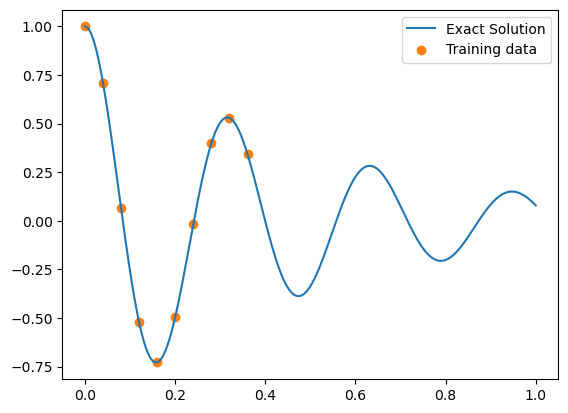

In [7]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(start=0, end=1, steps=500).reshape(-1, 1) # Δt = (end-start)/(steps-1)

y = exactOscillatorEquation(d, w0, x).reshape(-1, 1)

print(x.shape, y.shape)


x_data = x[0:200:20]
y_data = y[0:200:20]


print(x_data.shape, y_data.shape)


plt.figure()
plt.plot(x, y, label="Exact Solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [8]:
# help(torch.linspace)

In [9]:
def plot_result(x, y, x_data, y_data, yh, epoch, xp=None,):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural Network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.55)
    plt.ylim(-1.1, 1.55)
    plt.text(1.065,0.7, "Training step: %i"%(epoch+1),fontsize="xx-large",color="k")
    plt.axis("off")
#end-def

MyPINN(
  (layer1): Linear(in_features=1, out_features=64, bias=True)
  (tanh1): Tanh()
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (tanh2): Tanh()
  (layer3): Linear(in_features=64, out_features=64, bias=True)
  (tanh3): Tanh()
  (layer4): Linear(in_features=64, out_features=64, bias=True)
  (tanh4): Tanh()
  (layer5): Linear(in_features=64, out_features=1, bias=True)
)


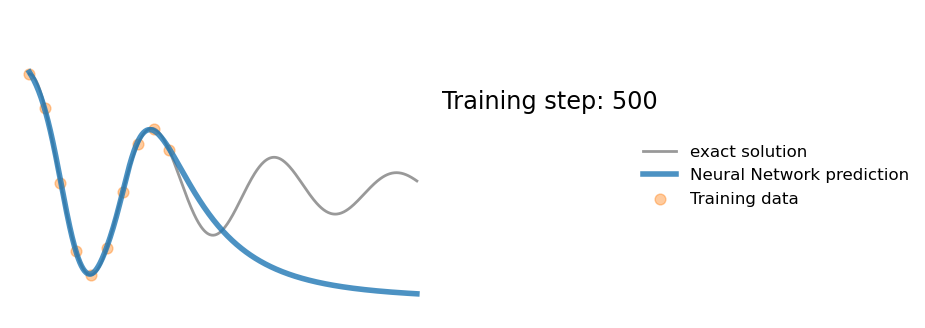

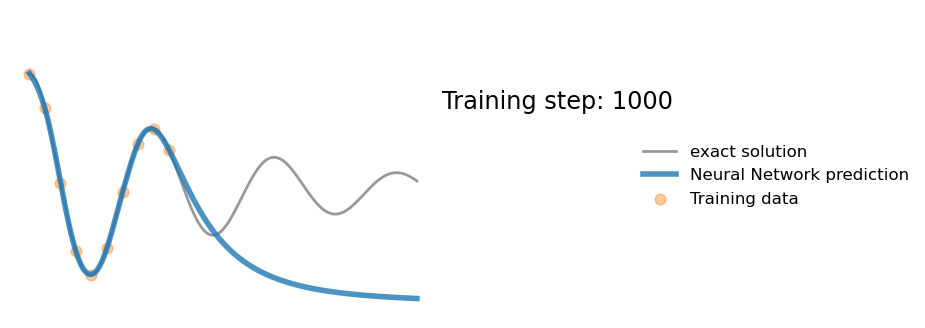

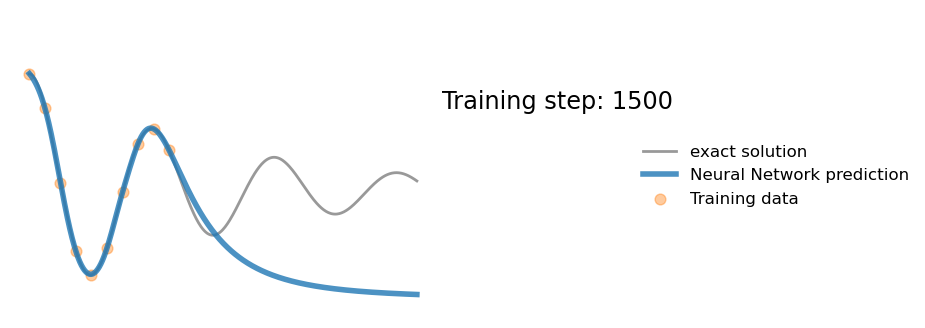

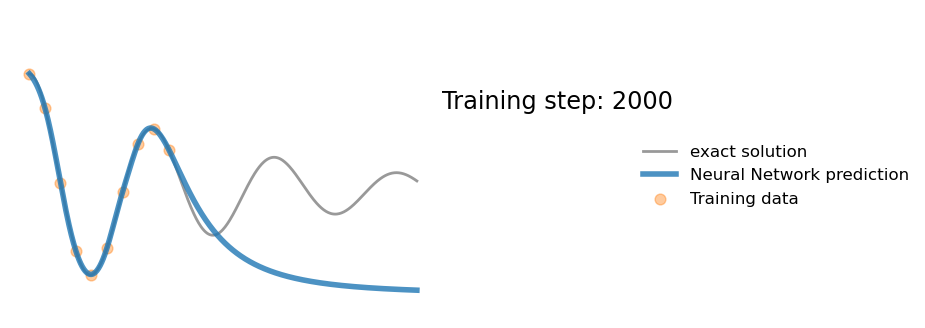

In [10]:
torch.manual_seed(3407) # https://arxiv.org/pdf/2109.08203.pdf

model = MyPINN(hiddenUnits=64)
print(model)

def trainModel(Epochs=1000, lr=0.01):
    
    #define optimizer:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(Epochs):
        # forward pass:
        yp = model(x_data)

        # computer loss:
        loss = torch.mean((yp-y_data)**2.0)

        # backward pass and optimization:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print after 1000 epochs:
        if (epoch+1) % 500 == 0:
            yp = model(x).detach()
            plot_result(x, y, x_data, y_data, yp, epoch)
            plt.show()
            
            # plt.plot(x, y, color="grey", linewidth=2, alpha=0.8, label="exact solution")
            # plt.plot(x, yp, color="tab:blue", linewidth=4, alpha=0.8, label="Neural Network prediction")
            # plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
            # plt.show()
            # plt.close('all')
        #end-if/else
    #end-for
    return
#end-def

trainModel(Epochs=2000, lr=1e-3)

#### 2. PINN to extrapolate the full solution outside of these training points

In [12]:
# torch.clone(v1).requires_grad_(True)
x_physics = torch.linspace(start=0, end=1, steps=30).reshape(-1, 1).requires_grad_(True)

# x_physics = torch.clone(x).requires_grad_(True)
# x_physics_train = x_physics[0:200:20]

# print(x_physics)
mu, k = 2*d, w0**2

torch.manual_seed(3407)

model = MyPINN(hiddenUnits=64)

def trainPINNmodel(Epochs=1000, lr=1e-4, lambda2=1e-4):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(Epochs):    
        # compute the "data loss"
        yh = model(x_data)

        # compute the "basic loss" mean squared error:
        loss1 = torch.mean((yh-y_data)**2.0)# use mean squared error

        # compute the "physics loss":
        yhp = model(x_physics)


        dx1  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
        dx2  = torch.autograd.grad(dx1, x_physics, torch.ones_like(dx1),  create_graph=True)[0]# computes d^2y/dx^2
        physics = dx2 + mu*dx1 + k*yhp # computes the residual of the 1D harmonic oscillator differential equation
        loss2 = lambda2*torch.mean(physics**2)

        # backpropagate joint loss:
        optimizer.zero_grad()
        loss = loss1 + loss2 # add two loss terms together
        loss.backward()
        optimizer.step()


        # plot the result as training progresses
        if (epoch+1) % 5000 == 0:

            yh = model(x).detach()
            xp = x_physics.detach()

            plot_result(x, y, x_data, y_data, yh, epoch, xp)
            plt.show()
        #end-if/else
    #end-for
    return
#end-def

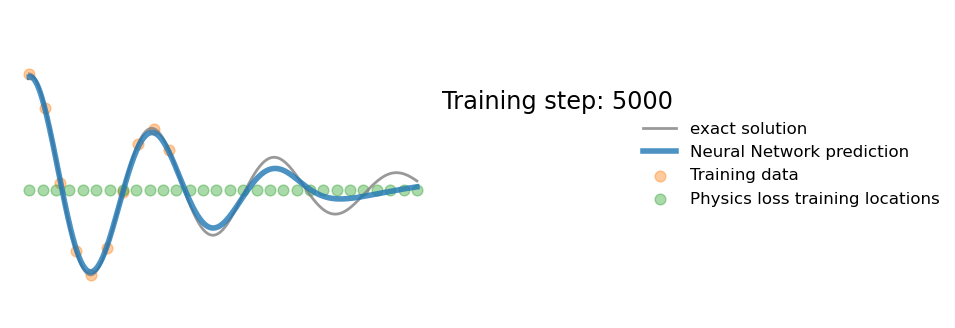

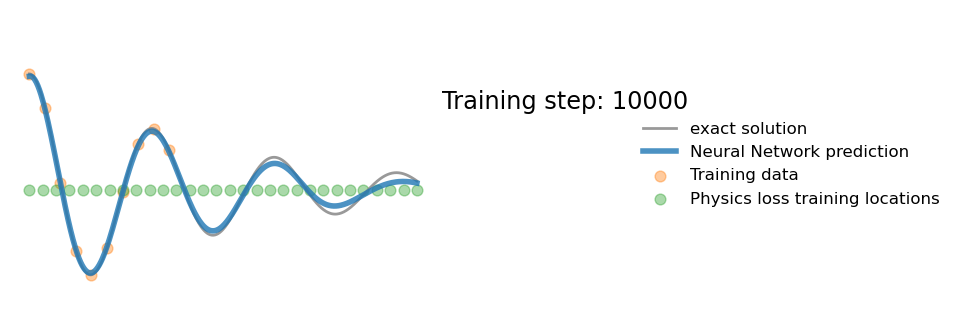

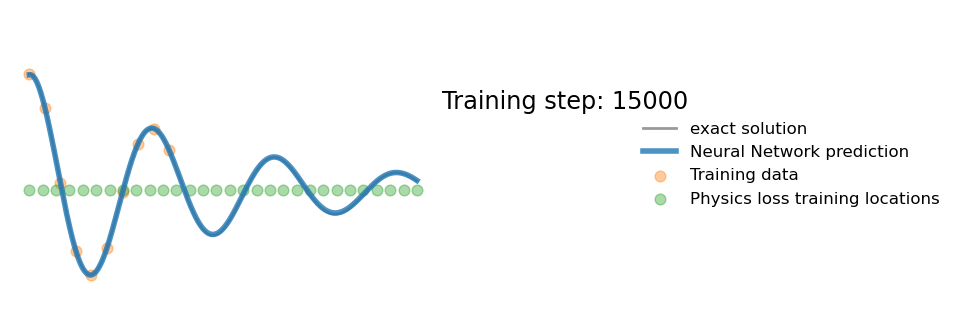

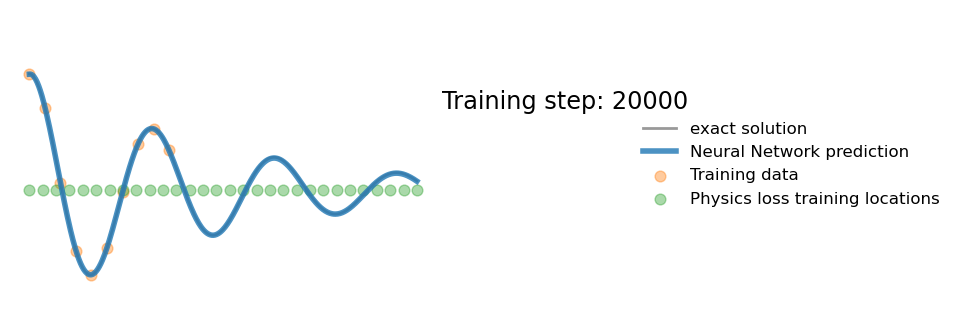

In [13]:
trainPINNmodel(Epochs=20000, lr=1e-3, lambda2=1e-4)

#### x. (ignore it) test some issues:

In [14]:
v1 = torch.tensor([
     [1,],
     [2,],
     [3,],
     [4.],
     [5,],
     [6,],
     [7,],
     [8,],
     [9,],
     [10,],
     [11,],
     [12,],
     [13,],
     [14,],
     [15,],
    

])

v2 = torch.clone(v1).requires_grad_(True)

# print(v1)
print(v2)

v2[0:8:2].detach()

tensor([[ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.]], requires_grad=True)


tensor([[1.],
        [3.],
        [5.],
        [7.]])